<a href="https://colab.research.google.com/github/zahrael97/CT_scan_Covid19_CNN/blob/master/ResNet/Ct_InceptionResNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Covid Detection using Transfer Learning**

In [1]:
# importing all the required libraries and modules

import numpy as np
import os, random
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wEteONprshoKjtXdciyLrFvFmwrNVP_nbtMcIu-xWOVHPvhzzz9nCc
Mounted at /content/drive


In [3]:
# Path of various directories
# Dataset : Chest X-Ray Images (Pneumonia) from Kaggle 

TRAIN_DIR = '/content/drive/My Drive/datasetCt/train'
TEST_DIR = '/content/drive/My Drive/datasetCt/test'
#VAL_DIR = '/content/drive/My Drive/chest_xray/val'

Covid_train = '/content/drive/My Drive/datasetCt/train/covid'
normal_train = '/content/drive/My Drive/datasetCt/train/normal'

Covid_test = '/content/drive/My Drive/datasetCt/test/covid'
normal_test = '/content/drive/My Drive/datasetCt/test/normal'

#pneumonia_val = '/content/drive/My Drive/chest_xray/val/PNEUMONIA'
#normal_val = '/content/drive/My Drive/chest_xray/val/NORMAL'

# **Customizing the InceptionResNetV3 model**

In [4]:
base_model=InceptionResNetV2(weights='imagenet',include_top=False)
# and slices off the top layer which is the one that classifies objects into various classes (we don't want this layer)

# Setting up the pre-trained weights of the inceptionv3 model as non-trainable
for layer in base_model.layers:
    layer.trainable=False       

# Adding new layers on top of the base model
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(2,activation='softmax')(x) #final layer with softmax activation - here, we have only 2 classes (Pneumonia & Normal)

219062272/219055592 [==============================] - 3s 0us/step


In [5]:
# Specify the inputs
# Specify the outputs
model=Model(inputs=base_model.inputs,outputs=preds)

# A new model has been created based on our architecture
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [6]:
# Name of all the layers in our new model which is built on top of the Inceptionv3 model (look at No. 311 till final layer)
for i,layer in enumerate(model.layers):
  print(i,layer.name)

0 input_1
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed_5b
41 conv2d_15
42 batch_normalization_15
43 activation_15
44 conv2d_13
45 conv2d_16
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 conv2d_12
51 conv2d_14
52 conv2d_17
53 batch_normalization_12
54 batch_normalization_14
55 batch_normalization_17
56 activa

## **Data Preparation**

In [7]:
def dir_file_count(directory):
  #Total number of files present inside the 'directory'
  return sum([len(files) for r, d, files in os.walk(directory)])

# Configuration parameters 
rescale = 1./255
target_size = (224, 224)
batch_size = 2            #Specifying the batch size
class_mode = 'categorical'

# Augment the training dataset images 
train_datagen = ImageDataGenerator(rescale=rescale,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)
# Load the images in the generator 
train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    target_size=target_size,
                                                    class_mode=class_mode,
                                                    batch_size=batch_size,
                                                    shuffle=True)
# Augment the validation dataset images
#val_datagen = ImageDataGenerator(rescale=rescale)
# Load the images in the generator
#val_generator = val_datagen.flow_from_directory(VAL_DIR, 
  #                                              target_size=target_size,
  #                                              class_mode=class_mode,
  #                                              batch_size=dir_file_count(VAL_DIR),
    #                                            shuffle=False)
# Augment the test dataset images
test_datagen = ImageDataGenerator(rescale=rescale,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)
# Load the images in the generator
test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  target_size=target_size,
                                                  class_mode=class_mode,
                                                  batch_size=dir_file_count(TEST_DIR),
                                                  shuffle=False)

Found 618 images belonging to 2 classes.
Found 130 images belonging to 2 classes.


# **Training Process of our custom model**

In [8]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# Loss function will be categorical cross entropy
# Evaluation metric will be accuracy

# Start the training
history = model.fit_generator(train_generator,
                              steps_per_epoch=len(train_generator),
                              epochs=30,                                # Specifying the no. of epochs
                              validation_data=test_generator,
                              validation_steps=len(test_generator))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
309/309 [==============================] - 488s 2s/step - loss: 0.8262 - accuracy: 0.5890 - val_loss: 0.6778 - val_accuracy: 0.5000
Epoch 2/30
309/309 [==============================] - 29s 93ms/step - loss: 0.6523 - accuracy: 0.6262 - val_loss: 0.6574 - val_accuracy: 0.5231
Epoch 3/30
309/309 [==============================] - 29s 93ms/step - loss: 0.6249 - accuracy: 0.6715 - val_loss: 0.9949 - val_accuracy: 0.5077
Epoch 4/30
309/309 [==============================] - 28s 92ms/step - loss: 0.5888 - accuracy: 0.7298 - val_loss: 0.5915 - val_accuracy: 0.7231
Epoch 5/30
309/309 [==============================] - 28s 92ms/step - loss: 0.5156 - accuracy: 0.7460 - val_loss: 0.5782 - val_accuracy: 0.6923
Epoch 6/30
309/309 [==============================] - 28s 92ms/step - loss: 0.5160 - accuracy: 0.7379 - val_loss: 0.6930 - val_accuracy: 0.7154
Epoch 7/30
309/309 [==============================] - 28s 92m

# **Evaluation metrics (Performance)**

In [9]:
y_pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)
y_pred = y_pred.argmax(axis=-1)
y_true = test_generator.classes

precision = precision_score(y_true, y_pred) 
recall = recall_score(y_true, y_pred) 
f1 = f1_score(y_true, y_pred) 
confusion = confusion_matrix(y_true, y_pred, labels=None, sample_weight=None, normalize=None)
print("-"*70)
print("Report")
print("-"*70)
print("%s%.2f%s"% ("Precision     : ", precision*100, "%"))
print("%s%.2f%s"% ("Recall        : ", recall*100,    "%"))
print("%s%.2f%s"% ("F1-Score      : ", f1*100,        "%"))
print("-"*70)
print("\n\n")

cls_report_print = classification_report(y_true, y_pred, target_names=['covid', 'Normal'])

cls_report = classification_report(y_true, y_pred, target_names=['covid', 'Normal'], output_dict=True)

print("-"*70)
print("covid Prediction")
print("-"*70)
print(cls_report_print)
print("-"*70)

print( confusion)

Instructions for updating:
Please use Model.predict, which supports generators.
1/1 [==============================] - 1s 1s/step
----------------------------------------------------------------------
Report
----------------------------------------------------------------------
Precision     : 77.36%
Recall        : 63.08%
F1-Score      : 69.49%
----------------------------------------------------------------------



----------------------------------------------------------------------
covid Prediction
----------------------------------------------------------------------
              precision    recall  f1-score   support

       covid       0.69      0.82      0.75        65
      Normal       0.77      0.63      0.69        65

    accuracy                           0.72       130
   macro avg       0.73      0.72      0.72       130
weighted avg       0.73      0.72      0.72       130

----------------------------------------------------------------------
[[53 12]
 [24 41]]


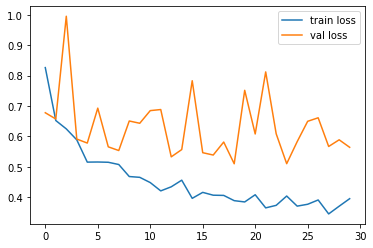

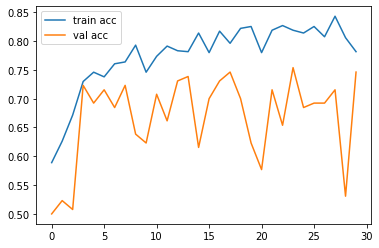

<Figure size 432x288 with 0 Axes>

In [10]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_accuracy')

import tensorflow as tf

from keras.models import load_model

model.save('InceptionV3.h5')